### Using dark emulator to describe the DMASS clustering/lensing signals

The instructions for installation are one the README of the Github repo: https://github.com/DarkQuestCosmology/dark_emulator_public
and also described on the documentation:
https://dark-emulator.readthedocs.io/en/latest/

For my given conda set-up, conda install failed, but pip worked. Check that it has properly installed by running `import dark_emulator` in ipython or ipython notebook. I currently get a message that `colossus is not installed.` but not sure yet whether this will impact our usage of dark emulator.

Sujeong has produced blinded Y1 DMASS correlation measurements, which live in
`/users/PCON0003/cond0080/DMASS/blinded_dmass_y1_small_scale` so these are what we will try to fit with the dark emulator.

In order to understand how the model works, you will need to do background reading on the halo model and halo occupation distribution (HOD). Will update with some good references here (e.g., the DES Y3 galaxy-galaxy lensing paper by Zacharegkas+ https://arxiv.org/abs/2106.08438 is one place to look but you may need to do a deeper search to get more details).

In [3]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)
pil_logger = logging.getLogger('PIL')
pil_logger.setLevel(logging.WARNING)
import os
import numpy as np
from astropy.io import fits
from dark_emulator import model_hod

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.figsize'] = (10,6)

### Testing dark emulator
We will eventually want to fit HOD parameters to a galaxy-galaxy lensing signal in DeltaSigma(R), so the first part of one of their notebooks shows the steps for setting these parameters and plotting them. This is reproduced below.

To learn what the actual parameters are, you will need to check the documentation. For example, two cells below there is an array called `cparam` which is passed to a function called `set_cosmology` which has documentation here: https://dark-emulator.readthedocs.io/en/latest/dark_emulator.model_hod.hod_interface.html#dark_emulator.model_hod.hod_interface.darkemu_x_hod.set_cosmology

In [3]:
# Initialization of a python class that sets cosmology, halo occupation distribution parameters (HOD), and more
hod = model_hod.darkemu_x_hod({"fft_num":8})
hod2 = model_hod.darkemu_x_hod({"fft_num":8})

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator
initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


In [4]:
cparam = np.array([0.02225,0.1198,0.6844,3.094,0.9645,-1.])
hod.set_cosmology(cparam)

gparam = {"logMmin":13.13, "sigma_sq":0.22, "logM1": 14.21, "alpha": 1.13, "kappa": 1.25, # HOD parameters
           "poff": 0.2, "Roff": 0.1, # off-centering parameters p_off is the fraction of off-centered galaxies. Roff is the typical off-centered scale with respect to R200m.
           "sat_dist_type": "emulator", # satellite distribution. Chosse emulator of NFW. In the case of NFW, the c-M relation by Diemer & Kravtsov (2015) is assumed.
           "alpha_inc": 0.44, "logM_inc": 13.57} # incompleteness parameters. For details, see More et al. (2015)
hod.set_galaxy(gparam)

INFO:root:Got same cosmology. Keep quantities already computed.


In [5]:
cparam2 = np.array([0.02225,0.1198,0.6844,3.094,0.9645,-1.])
hod2.set_cosmology(cparam2)
gparam2 = {"logMmin":13.94, "sigma_sq":0.22, "logM1": 14.46, "alpha": 1.192, "kappa": 0.6, # HOD parameters
           "poff": 0.2, "Roff": 0.1, # off-centering parameters p_off is the fraction of off-centered galaxies. Roff is the typical off-centered scale with respect to R200m.
           "sat_dist_type": "emulator", # satellite distribution. Choose emulator or NFW. In the case of NFW, the c-M relation by Diemer & Kravtsov (2015) is assumed.
           "alpha_inc": 0.44, "logM_inc": 13.57} # incompleteness parameters. For details, see More et al. (2015)
hod2.set_galaxy(gparam2)

INFO:root:Got same cosmology. Keep quantities already computed.


In [6]:
redshift = 0.484  # This is roughly the midpoint of the CMASS redshift range (0.43-0.7)
r = np.logspace(-1,2,100)  # Somewhat arbitrary choice of physical separation "r"

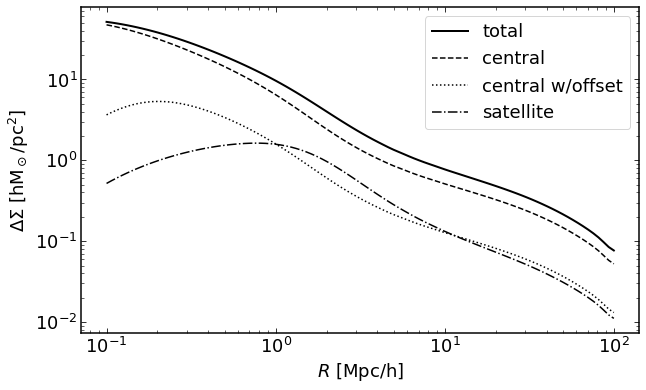

In [7]:
# Standard delta Sigma
plt.figure(figsize=(10,6))

# Plot each of the different halo model components
plt.loglog(r, hod.get_ds(r, redshift), linewidth = 2, color = "k", label = "total")
plt.loglog(r, hod.get_ds_cen(r, redshift), "--", color = "k", label = "central")
plt.loglog(r, hod.get_ds_cen_off(r, redshift), ":", color = "k", label = "central w/offset")
plt.loglog(r, hod.get_ds_sat(r, redshift), "-.", color = "k", label = "satellite")

plt.xlabel(r"$R$ [Mpc/h]")
plt.ylabel(r"$\Delta\Sigma$ [hM$_\odot$/pc$^2$]")
plt.legend()

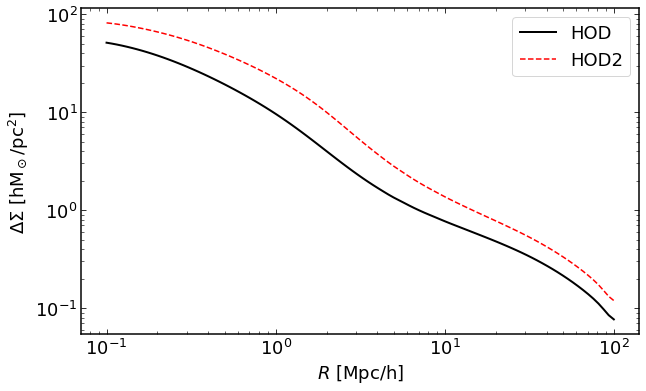

In [8]:
# Compare different HOD parameters
plt.figure(figsize=(10,6))

# Plot each of the different halo model components
plt.loglog(r, hod.get_ds(r, redshift), linewidth = 2, color = "k", label = "HOD")
plt.loglog(r, hod2.get_ds(r, redshift), "--", color = "r", label = "HOD2")

plt.xlabel(r"$R$ [Mpc/h]")
plt.ylabel(r"$\Delta\Sigma$ [hM$_\odot$/pc$^2$]")
plt.legend()

### Fitting the dark emulator model to the DMASS Y1 galaxy-galaxy lensing signal

We want to fit the model to our signal but we have the model for $\Delta \Sigma (R)$ and we have the measured DMASS Y1 galaxy-galaxy lensing signal in $\gamma_{T}(\theta)$. We need to convert one to the other.

In [5]:
fdir = '/users/PCON0003/cond0080/DMASS/blinded_dmass_y1_small_scale'
filein = 'simulated_y1_dmass_3x2pt_baseline_small_scales.fits'

# Open up the file
hdu = fits.open(os.path.join(fdir, filein))

print(hdu.info())
# The galaxy-galaxy lensing signal is stored here with the name "galaxy_shear_xi"
# Ignore the other extensions for now, they correspond to cosmic shear and galaxy clustering
ggl_hdu_header = hdu[3].header
ggl_hdu = hdu[3].data
# Printing ggl_hdu_header indicates that ggl_hdu contains bin1, bin2, angbin, value, ang
# where bin1 is the redshift bin number for the foreground positions (here for DMASS this is always 1)
# bin2 is the redshift bin number for the background source galaxy shapes (there are four source redshift bins in total)
print(ggl_hdu_header)

Filename: /users/PCON0003/cond0080/DMASS/blinded_dmass_y1_small_scale/simulated_y1_dmass_3x2pt_baseline_small_scales.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  shear_xi_plus    1 BinTableHDU     29   300R x 5C   [K, K, K, D, D]   
  2  shear_xi_minus    1 BinTableHDU     29   300R x 5C   [K, K, K, D, D]   
  3  galaxy_shear_xi    1 BinTableHDU     29   120R x 5C   [K, K, K, D, D]   
  4  galaxy_xi     1 BinTableHDU     29   30R x 5C   [K, K, K, D, D]   
  5  nz_source     1 BinTableHDU     24   401R x 7C   [D, D, D, D, D, D, D]   
  6  nz_lens       1 BinTableHDU     18   401R x 4C   [D, D, D, D]   
None
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   40 / length of dimension 1              

Printing ggl_hdu_header indicates that ggl_hdu contains bin1, bin2, angbin, value, ang where:
* bin1 is the redshift bin number for the foreground positions (here for DMASS this is always 1)
* bin2 is the redshift bin number for the background source galaxy shapes (there are four source redshift bins in total)
* angbin is the number of the theta bin
* value is $\gamma_{T}$ for the given theta bin
* ang is the theta value.

In [6]:
# Helpful to take one set of gamma_T points (e.g., DMASS cross-correlated with redshift bin 4) and plot them

In [7]:
# Since the simulation fits file is in the standard DES 2point format we can use Joe's 2point module for plotting.
# as of 8/16/2022, the module does not work with the latest version of matplotlib. A modified version is available and Joe has been notified.

In [10]:
import twopoint
import os
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

matplotlib version 3.5.1. use nonpositive True


In [11]:
des_filename = '/users/PCON0003/cond0080/DMASS/blinded_dmass_y1_small_scale/simulated_y1_dmass_3x2pt_baseline_small_scales'
des_file = des_filename +'.fits'
# the simulated fits file does not include covariance information
Td=twopoint.TwoPointFile.from_fits(des_file,covmat_name=None)

In [12]:
# Here is a look at the extension structure of the simulated fits file:
import fitsio
f2=fitsio.FITS(des_file,'r')
print(f2)


  file: /users/PCON0003/cond0080/DMASS/blinded_dmass_y1_small_scale/simulated_y1_dmass_3x2pt_baseline_small_scales.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      shear_xi_plus
  2      BINARY_TBL      shear_xi_minus
  3      BINARY_TBL      galaxy_shear_xi
  4      BINARY_TBL      galaxy_xi
  5      BINARY_TBL      nz_source
  6      BINARY_TBL      nz_lens


Saving /users/PAS1330/osu9396/DMASS/2point/small_scale_shear_nz_source
Saving /users/PAS1330/osu9396/DMASS/2point/small_scale_shear_nz_lens


<Figure size 720x432 with 0 Axes>

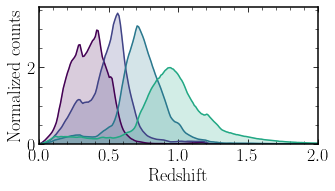

<Figure size 720x432 with 0 Axes>

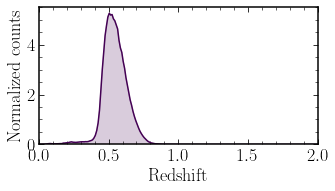

In [13]:
# Plot the lens and source redshift distributions
# The first argument is the location and prefix for the image files (in png format)
Td.plots('/users/PAS1330/osu9396/DMASS/2point/small_scale_shear', colormap='viridis', savepdf=False, latex=True, plot_spectrum=False, plot_kernel=True, plot_cov=False, cov_vmin=None, sharey=True, save_pickle=False, load_pickle=False, remove_pickle=True,label_legend = None, blind_yaxis=False, shade_until=None)

In [14]:
# Plot gamma t and clustering
# For some reasons, these plots and not shown in the notebook but only appear on disk
Td.plots('/users/PAS1330/osu9396/DMASS/2point/small_scale_shear', colormap='viridis', savepdf=False, latex=True, plot_spectrum=True, plot_kernel=False, plot_cov=False, cov_vmin=None, sharey=True, save_pickle=False, load_pickle=False, remove_pickle=True,label_legend = None, blind_yaxis=False, shade_until=None)

Name /users/PAS1330/osu9396/DMASS/2point/small_scale_shear_shear_xi_plus bins1 4 bins2 4


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


k 0, pair (1, 1)
k 1, pair (1, 2)
k 2, pair (1, 3)
k 3, pair (1, 4)
k 4, pair (2, 2)
k 5, pair (2, 3)
k 6, pair (2, 4)
k 7, pair (3, 3)
k 8, pair (3, 4)
k 9, pair (4, 4)
Saving /users/PAS1330/osu9396/DMASS/2point/small_scale_shear_shear_xi_plus
Name /users/PAS1330/osu9396/DMASS/2point/small_scale_shear_shear_xi_minus bins1 4 bins2 4
k 0, pair (1, 1)
k 1, pair (1, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


k 2, pair (1, 3)
k 3, pair (1, 4)
k 4, pair (2, 2)
k 5, pair (2, 3)
k 6, pair (2, 4)
k 7, pair (3, 3)
k 8, pair (3, 4)
k 9, pair (4, 4)
Saving /users/PAS1330/osu9396/DMASS/2point/small_scale_shear_shear_xi_minus


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Name /users/PAS1330/osu9396/DMASS/2point/small_scale_shear_galaxy_shear_xi bins1 1 bins2 4
k 0, pair (1, 1)
0, (1, 1), (4,)
k 1, pair (1, 2)
1, (1, 2), (4,)
k 2, pair (1, 3)
2, (1, 3), (4,)
k 3, pair (1, 4)
3, (1, 4), (4,)
Saving /users/PAS1330/osu9396/DMASS/2point/small_scale_shear_galaxy_shear_xi


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Name /users/PAS1330/osu9396/DMASS/2point/small_scale_shear_galaxy_xi bins1 1 bins2 1
k 0, pair (1, 1)
Saving /users/PAS1330/osu9396/DMASS/2point/small_scale_shear_galaxy_xi


In [ ]:
# Next exercise here is to either convert the gamma_T to Delta Sigma or vice-versa...